In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 


In [2]:
fin_luh2 = xr.open_dataset('LUH2_states_transitions_management.timeseries_4x5_hist_simyr1650-2015_c240216.nc')

fin_luh2['time'] = fin_luh2.time+850

In [3]:
nages = 300
ntime_total = len(fin_luh2.time)
IM = len(fin_luh2.lon)
JM = len(fin_luh2.lat)

ages = np.arange(nages)

age_mature=94

In [4]:
area_prim = fin_luh2.primf + fin_luh2.primn


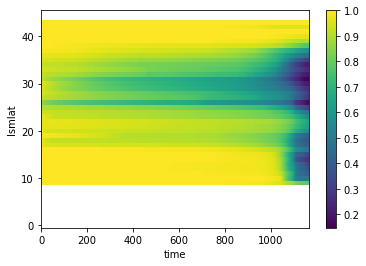

In [5]:
area_prim.mean(dim='lsmlon').plot(y='lsmlat',x='time')

In [6]:
rate_newsec_creation = fin_luh2.primf_harv + fin_luh2.primn_harv + fin_luh2.primf_to_secdn + fin_luh2.primn_to_secdf  + fin_luh2.urban_to_secdf  + fin_luh2.urban_to_secdn  + fin_luh2.c3ann_to_secdf  + fin_luh2.c3ann_to_secdn  + fin_luh2.c4ann_to_secdf  + fin_luh2.c4ann_to_secdn  + fin_luh2.c3per_to_secdf  + fin_luh2.c3per_to_secdn  + fin_luh2.c4per_to_secdf  + fin_luh2.c4per_to_secdn  + fin_luh2.c3nfx_to_secdf  + fin_luh2.c3nfx_to_secdn  + fin_luh2.pastr_to_secdf  + fin_luh2.pastr_to_secdn  + fin_luh2.range_to_secdf  + fin_luh2.range_to_secdn 

rate_sec_loss_transitions = fin_luh2.secdf_to_urban + fin_luh2.secdf_to_c3ann + fin_luh2.secdf_to_c4ann + fin_luh2.secdf_to_c3per + fin_luh2.secdf_to_c4per + fin_luh2.secdf_to_c3nfx + fin_luh2.secdf_to_pastr + fin_luh2.secdf_to_range + fin_luh2.secdn_to_urban + fin_luh2.secdn_to_c3ann + fin_luh2.secdn_to_c4ann + fin_luh2.secdn_to_c3per + fin_luh2.secdn_to_c4per + fin_luh2.secdn_to_c3nfx + fin_luh2.secdn_to_pastr + fin_luh2.secdn_to_range

secmf_harv = fin_luh2.secmf_harv
secyf_harv = fin_luh2.secyf_harv
secnf_harv = fin_luh2.secnf_harv


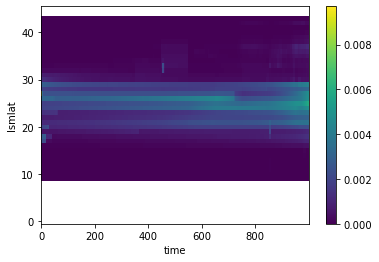

In [7]:
rate_newsec_creation.isel(time=slice(0,1000)).mean(dim='lsmlon').plot(y='lsmlat',x='time')

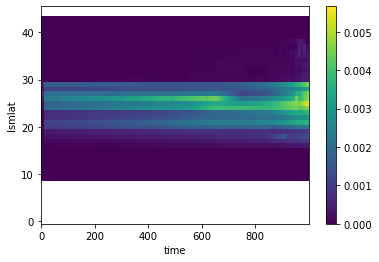

In [8]:
rate_sec_loss_transitions.isel(time=slice(0,1000)).mean(dim='lsmlon').plot(y='lsmlat',x='time')

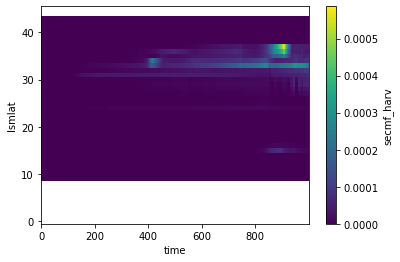

In [9]:
secmf_harv.isel(time=slice(0,1000)).mean(dim='lsmlon').plot(y='lsmlat',x='time')

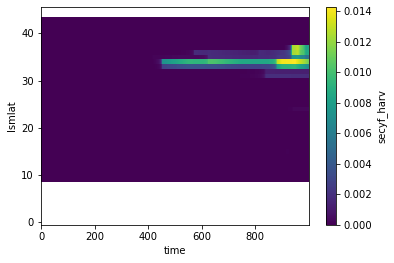

In [10]:
secyf_harv.isel(time=slice(0,1000)).mean(dim='lsmlon').plot(y='lsmlat',x='time')

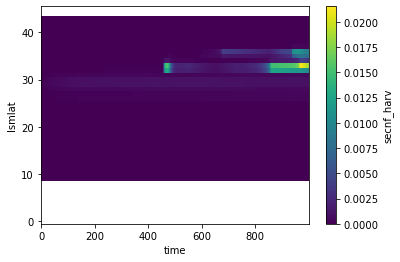

In [11]:
secnf_harv.isel(time=slice(0,1000)).mean(dim='lsmlon').plot(y='lsmlat',x='time')

In [12]:
age_dist = xr.DataArray(np.zeros((ntime_total,nages,JM,IM)), dims=['time','age','lsmlat','lsmlon'], coords=[fin_luh2.time, ages, fin_luh2.lsmlat, fin_luh2.lsmlon])



In [13]:
secnf_harv

<xarray.DataArray 'secnf_harv' (time: 1166, lsmlat: 46, lsmlon: 72)>
[3861792 values with dtype=float64]
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.163e+03 1.164e+03 1.165e+03
    lon      (lsmlon) float64 ...
    lat      (lsmlat) float64 ...
Dimensions without coordinates: lsmlat, lsmlon

In [14]:
### initialize the secondary forest age as having all zero age at start of dataset

sectot = fin_luh2.secdf + fin_luh2.secdn
age_dist[0,0,:,:] = sectot.isel(time=0)

In [15]:
for t in range(ntime_total-1):
    if t%50 == 0:
        print('starting year ',t)
    secy = age_dist.isel(time=t).isel(age=slice(0,age_mature)).sum(dim='age')
    secm = age_dist.isel(time=t).isel(age=slice(age_mature,None)).sum(dim='age')
    
    age_dist[t+1,0,:,:] = rate_newsec_creation.isel(time=t)
    aaa = np.minimum(1.,np.nan_to_num(rate_sec_loss_transitions.isel(time=t)/sectot.isel(time=t)))
    bbb = np.minimum(1.,np.nan_to_num(secyf_harv.isel(time=t)/secy))
    ccc = np.minimum(1.,np.nan_to_num(secnf_harv.isel(time=t)/sectot.isel(time=t)))
    ddd = np.minimum(1.,np.nan_to_num(secmf_harv.isel(time=t)/secm))

    for age in range(age_mature):
        age_dist[t+1,age+1] = age_dist[t,age] * (1. - np.minimum(1.,(aaa + bbb + ccc)))
        age_dist[t+1,0] = age_dist[t+1,0] + age_dist[t,age] * np.minimum(1.,(bbb + ccc))
    for age in range(age_mature,nages-2):
        age_dist[t+1,age+1] = age_dist[t,age] * (1.- np.minimum(1.,(aaa + ddd + ccc)))
        age_dist[t+1,0] = age_dist[t+1,0] + age_dist[t,age] * np.minimum(1.,(ddd + ccc))
    age_dist[t+1,nages-1] = (age_dist[t,nages-1] + age_dist[t,nages-2]) * (1.- np.minimum(1.,(aaa + ddd + ccc)))
    age_dist[t+1,0] = age_dist[t+1,0] + (age_dist[t,nages-1] + age_dist[t,nages-2]) * np.minimum(1.,(ddd + ccc))


starting year  0
starting year  50
starting year  100
starting year  150
starting year  200
starting year  250
starting year  300
starting year  350
starting year  400
starting year  450
starting year  500
starting year  550
starting year  600
starting year  650
starting year  700
starting year  750
starting year  800
starting year  850
starting year  900
starting year  950
starting year  1000
starting year  1050
starting year  1100
starting year  1150


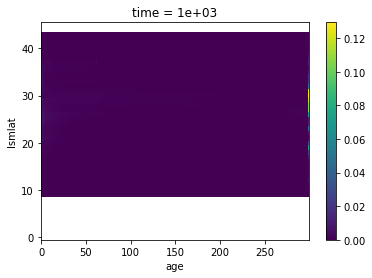

In [16]:
age_dist.isel(time=1000).mean(dim='lsmlon').plot(x='age',y='lsmlat')

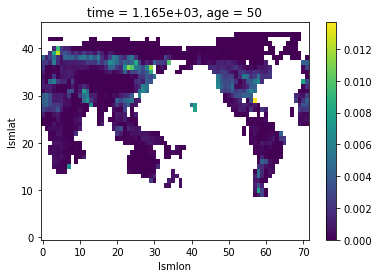

In [20]:
age_dist.isel(time=-1).isel(age=50).plot(x='lsmlon',y='lsmlat')

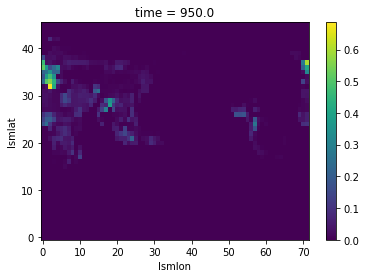

In [23]:
age_dist.isel(time=950).isel(age=slice(0,20)).sum(dim='age').plot(x='lsmlon',y='lsmlat')

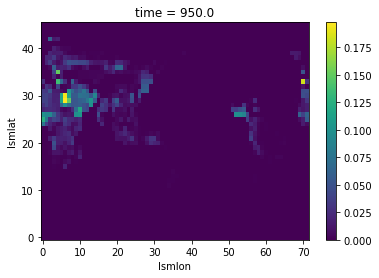

In [24]:
age_dist.isel(time=950).isel(age=slice(20,50)).sum(dim='age').plot(x='lsmlon',y='lsmlat')

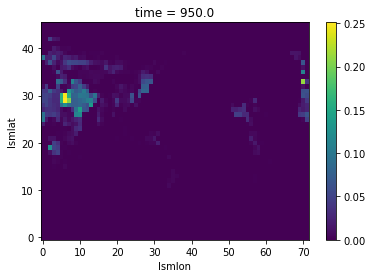

In [25]:
age_dist.isel(time=950).isel(age=slice(50,100)).sum(dim='age').plot(x='lsmlon',y='lsmlat')

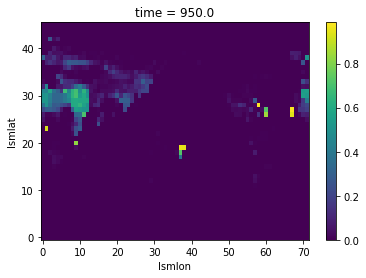

In [29]:
age_dist.isel(time=950).isel(age=slice(100,None)).sum(dim='age').plot(x='lsmlon',y='lsmlat')

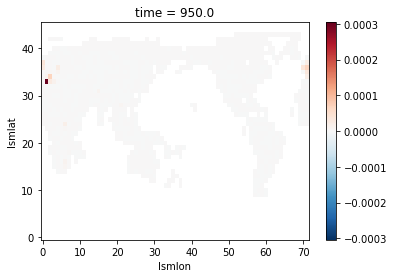

In [30]:
(age_dist.isel(time=950).sum(dim='age') - sectot.isel(time=950)).plot()

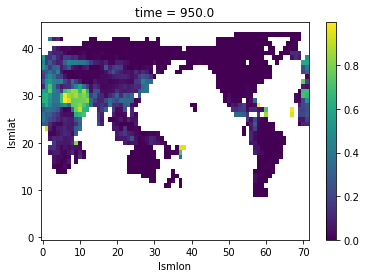

In [33]:
(sectot.isel(time=950)).plot()